# SISTER Production Summary

In [95]:
import json
import os
import pandas as pd
import IPython
import datetime as dt 
import re
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from maap.maap import MAAP
maap = MAAP(maap_host="sister-api.imgspec.org")

### Get list of jobs

_Rerun to retreive up-to-date job list_

In [2]:
job_list = maap.listJobs('anonymous').text
jobs  = json.loads(job_list)

### Set regex pattern to match tags

In [3]:
crid= "001"
pattern = f"^SISTER.*T.*.*{crid}$"

### Cycle through jobs and store job information for tags matching regex pattern
_If duplicate tags exists only most recently run job is retained_

TODO: Retain all jobs, index by job ID instead of tag

In [97]:
production = {}
crid= "001"

for job in jobs['jobs']:
    job_id = list(job.keys())[0]
    tag = job[job_id]['tags'][0]
    tag = tag.upper()

    if re.match(pattern,tag):

        job_info = {}
        job_info['status'] = job[job_id]['status'].replace('job-','')
        
        if 'CWL' in tag:
            sister,sensor,product,datetime,crid = tag.split('_')
            job_info['PGE'] = product
        else:
            sister,sensor,level,product,datetime,crid = tag.split('_')
            job_info['PGE'] = f'{level}_{product}'

        job_info['sensor'] = sensor

        if 'time_start' in job[job_id]['job']['job_info'].keys():
            start_time = job[job_id]['job']['job_info']['time_start']
        else:
            start_time = '2000-01-01T00:00:00.0Z'
        job_info['start_time'] =dt.datetime.strptime(start_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'time_end' in job[job_id]['job']['job_info'].keys():
            end_time = job[job_id]['job']['job_info']['time_end']
        else:
            end_time = '2000-01-01T00:00:00.0Z'
        job_info['end_time'] =dt.datetime.strptime(end_time,'%Y-%m-%dT%H:%M:%S.%fZ')

        if 'duration' in job[job_id]['job']['job_info'].keys():
            job_duration = float(job[job_id]['job']['job_info']['duration'])/60
        else:
            job_duration = -1

        job_info['duration'] =job_duration

        instance_type = np.nan
        cores = np.nan
        memory = np.nan

        if 'facts' in job[job_id]['job']['job_info'].keys():
            if 'ec2_instance_type' in job[job_id]['job']['job_info']['facts'].keys():
                instance_type = job[job_id]['job']['job_info']['facts']['ec2_instance_type']

            if 'processorcount' in job[job_id]['job']['job_info']['facts'].keys():
                cores = job[job_id]['job']['job_info']['facts']['processorcount']

            if 'processorcount' in job[job_id]['job']['job_info']['facts'].keys():
                memorysize = float(job[job_id]['job']['job_info']['facts']['memorysize'].split()[0])
                memoryfree = float(job[job_id]['job']['job_info']['facts']['memoryfree'].split()[0])
                memory = memorysize - memoryfree

        job_info['instance_type'] = instance_type
        job_info['cores'] = cores
        job_info['memory'] = memory
        
        output_datasets = []
        input_datasets = []
        inputs_disk_usage = 0
        staged_disk_usage = 0

        if job_info['status'] == 'completed':
            if 'metrics' in job[job_id]['job']['job_info'].keys():
                for staged in job[job_id]['job']['job_info']['metrics']['products_staged']:
                    if staged['dataset_type'].startswith('L'):
                        staged_disk_usage+=staged['disk_usage']/1E9
                        for url in staged['urls']:
                            if url.startswith('http'):
                                output_datasets.append(url)

            for input_dataset in job[job_id]['job']['job_info']['metrics']['inputs_localized']:
                inputs_disk_usage += input_dataset['disk_usage']/1E9
                input_datasets.append(input_dataset['url'])


        job_info['output_datasets'] = output_datasets
        job_info['input_datasets'] = input_datasets
        job_info['inputs_disk_usage'] = inputs_disk_usage
        job_info['staged_disk_usage'] = staged_disk_usage
        job_info['tag'] = tag
        production[job_id] = job_info

## Create production results dataframe
---

In [103]:
production_df = pd.DataFrame(index = production.keys(),
                        columns = job_info.keys())

for tag in production.keys():
    production_df.loc[tag,:] = [production[tag][key] for key in job_info.keys()]
    
production_df['core_hours'] = production_df['cores']*(production_df['duration']/60)
    
prod_complete = pd.DataFrame(columns = production_df.columns)

for tag,group in  production_df[production_df.status != 'failed'].groupby(by ='tag'):
    index =np.argmax(group.end_time)
    group.iloc[index].name
    prod_complete.loc[group.iloc[index].tag,:] = group.iloc[index]
    
metrics = ['duration','inputs_disk_usage','staged_disk_usage']   
prod_complete.index.name = 'tag'
prod_complete[['sensor','PGE']+metrics+['instance_type']].to_csv("./sister_production_run_2_metrics.csv")    

## Get job statistics by sensor and PGE

In [104]:
production_mean = prod_complete.groupby(['sensor','PGE']).mean()[metrics]
production_mode = prod_complete.groupby(['sensor','PGE']).agg( lambda x: pd.Series.mode(x)[0])['instance_type']
production_count = prod_complete.groupby(['sensor','PGE']).count()
production_mean

duration  inputs_disk_usage  staged_disk_usage
sensor PGE                                                             
AVCL   CWL             164.506690           0.000000           0.000000
       L1B_RDN          23.783402           3.127971           3.352559
       L2A_CORFL         5.904507           3.255145           3.108161
       L2A_RFL         104.393039           3.490446           6.593808
       L2A_RSRFL         6.208197           6.593808           6.211144
       L2B_FRCOVER       9.069355           3.108158           0.039066
       L2B_GRAINSIZE     1.485242           3.160614           0.000595
       L2B_ROUTER        0.343597           0.039016           0.000000
       L2B_VEGBIOCHEM    2.092524           3.147224           0.039755
AVNG   CWL              62.580039           0.000000           0.000000
       L1B_RDN          11.377635           8.427250           0.300307
       L2A_CORFL         1.208017           0.155608           0.140937
       L2A_RFL          23.082712           0.300307           0.567201
       L2A_RSRFL         1.157895           0.567201           0.281576
       L2B_FRCOVER       5.505384           0.140934           0.002292
       L2B_GRAINSIZE     0.453856           0.143764           0.000102
       L2B_ROUTER        0.316521           0.002367           0.000000
       L2B_VEGBIOCHEM    0.619588           0.151247           0.003298
DESIS  CWL              47.242161           0.000000           0.000000
       L1B_RDN           2.274061           0.565167           2.156578
       L2A_CORFL         1.251145           0.612749           0.525495
       L2A_RFL          18.512363           2.156578           4.084326
       L2A_RSRFL         1.854013           4.084326           1.048841
       L2B_FRCOVER       5.846822           0.525492           0.012960
       L2B_ROUTER        0.201349           0.012960           0.000000
       L2B_VEGBIOCHEM    0.859793           0.535121           0.004938
PRISMA CWL              52.929053           0.000000           0.000000
       L1B_RDN           6.506373           0.804011           1.407589
       L2A_CORFL         1.603719           1.274806           1.217180
       L2A_RFL          21.039917           1.401521           2.651463
       L2A_RSRFL         2.157486           2.651463           2.432379
       L2B_FRCOVER       6.919833           1.217177           0.013483
       L2B_GRAINSIZE     0.596753           1.230660           0.000600
       L2B_ROUTER        0.301790           0.013483           0.000000
       L2B_VEGBIOCHEM    1.001216           1.230660           0.008583

## Print CSV

In [49]:
PGEs = {'CWL':'CWL Workflow',
         'L1B_RDN':'L1 Preprocess',
         'L2A_RFL':'L2 ISOFIT',
         'L2A_RSRFL' :'L2 Resample',
         'L2A_CORFL':'L2 Correction',
         'L2B_ROUTER': 'L2 Router',
         'L2B_FRCOVER':'L2 Fractional Cover',
         'L2B_GRAINSIZE':'L2 Snow grain size',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits',}


sensors = {'AVCL': 'AVIRIS-CL',
           'AVNG': 'AVIRIS-NG',
           'PRISMA':'PRISMA',
           'DESIS':'DESIS'}

for pge in PGEs.keys():
    for sensor in sensors.keys():
        if (sensor == 'DESIS') & (pge == 'L2B_GRAINSIZE'):
            continue
        else:
            row = production_mean.loc[(sensor,pge)].values.round(3).astype(str).tolist()
            instance_type = production_mode.loc[(sensor,pge)]
            count  = str(production_count.loc[(sensor,pge),'tag'])

            print(','.join([f'{PGEs[pge]} - {sensors[sensor]}'] + row + [instance_type,count]))


CWL Workflow - AVIRIS-CL,164.507,0.0,0.0,t3a.large,23
CWL Workflow - AVIRIS-NG,62.58,0.0,0.0,t3a.large,59
CWL Workflow - PRISMA,52.929,0.0,0.0,t3.large,27
CWL Workflow - DESIS,47.242,0.0,0.0,t3.large,8
L1 Preprocess - AVIRIS-CL,23.783,3.128,3.353,c5.9xlarge,25
L1 Preprocess - AVIRIS-NG,11.378,8.427,0.3,t3.xlarge,61
L1 Preprocess - PRISMA,6.506,0.804,1.408,t3a.xlarge,28
L1 Preprocess - DESIS,2.274,0.565,2.157,t3a.xlarge,8
L2 ISOFIT - AVIRIS-CL,104.393,3.49,6.594,c5.9xlarge,24
L2 ISOFIT - AVIRIS-NG,23.083,0.3,0.567,c5.9xlarge,61
L2 ISOFIT - PRISMA,21.04,1.402,2.651,c5.9xlarge,27
L2 ISOFIT - DESIS,18.512,2.157,4.084,c5.9xlarge,8
L2 Resample - AVIRIS-CL,6.208,6.594,6.211,t3a.xlarge,24
L2 Resample - AVIRIS-NG,1.158,0.567,0.282,t3.xlarge,61
L2 Resample - PRISMA,2.157,2.651,2.432,t3a.xlarge,27
L2 Resample - DESIS,1.854,4.084,1.049,t3.xlarge,8
L2 Correction - AVIRIS-CL,5.905,3.255,3.108,t3.xlarge,24
L2 Correction - AVIRIS-NG,1.208,0.156,0.141,t3.xlarge,61
L2 Correction - PRISMA,1.604,1.275,1.2

# Deliverable counts

In [50]:
deliverables = [
         'L2A_RSRFL',
         'L2A_CORFL',
         'L2B_FRCOVER',
         'L2B_GRAINSIZE',
         'L2B_VEGBIOCHEM']

deliver_df = prod_complete[[x in deliverables for x in prod_complete.PGE]]
deliver_count = deliver_df.groupby(['sensor','PGE']).count()
deliver_count[['tag']]

tag
sensor PGE                
AVCL   L2A_CORFL        24
       L2A_RSRFL        24
       L2B_FRCOVER      24
       L2B_GRAINSIZE    23
       L2B_VEGBIOCHEM   24
AVNG   L2A_CORFL        61
       L2A_RSRFL        61
       L2B_FRCOVER      61
       L2B_GRAINSIZE    54
       L2B_VEGBIOCHEM   55
DESIS  L2A_CORFL         8
       L2A_RSRFL         8
       L2B_FRCOVER       8
       L2B_VEGBIOCHEM    7
PRISMA L2A_CORFL        27
       L2A_RSRFL        27
       L2B_FRCOVER      27
       L2B_GRAINSIZE    27
       L2B_VEGBIOCHEM   27

In [22]:
print(f"Total production data volume: {prod_complete['staged_disk_usage'].sum()} Gb")
print(f"Total delivery data volume: {deliver_count['staged_disk_usage'].sum()} Gb")

Total production data volume: 819.4640518830003 Gb
Total delivery data volume: 577 Gb


### Production volume

In [87]:
product_PGEs = {
         'L1B_RDN':'L1 Preprocess',
         'L2A_RFL':'L2 ISOFIT',
         'L2A_RSRFL' :'L2 Resample',
         'L2A_CORFL':'L2 Correction',
         'L2B_FRCOVER':'L2 Fractional Cover',
         'L2B_GRAINSIZE':'L2 Snow grain size',
         'L2B_VEGBIOCHEM':'L2 Vegetation Traits'}

volume_stats = prod_complete.groupby(by = ['sensor','PGE']).agg({'staged_disk_usage':['sum','mean']})

for sensor in sensors.keys():

    stats = []

    for pge in product_PGEs.keys():
        if pge in volume_stats.loc[sensor].index: 
            pge_stats= volume_stats.loc[sensor].loc[pge].astype(float)

            stats+=pge_stats.round(2).values.tolist()
            stats.append(" ")

    print(sensor + "," + ','.join([str(x) for x in stats]))

AVCL,83.81,3.35, ,158.25,6.59, ,149.07,6.21, ,74.6,3.11, ,0.94,0.04, ,0.01,0.0, ,0.95,0.04, 
AVNG,18.32,0.3, ,34.6,0.57, ,17.18,0.28, ,8.6,0.14, ,0.14,0.0, ,0.01,0.0, ,0.18,0.0, 
PRISMA,39.41,1.41, ,71.59,2.65, ,65.67,2.43, ,32.86,1.22, ,0.36,0.01, ,0.02,0.0, ,0.23,0.01, 
DESIS,17.25,2.16, ,32.67,4.08, ,8.39,1.05, ,4.2,0.53, ,0.1,0.01, ,0.03,0.0, 


### Job duration table

In [94]:
product_PGEs = {
         'L1B_RDN':'L1B Preprocess',
         'L2A_RFL':'L2A ISOFIT',
         'L2A_RSRFL' :'L2A Resample',
         'L2A_CORFL':'L2A Correction',
         'L2B_FRCOVER':'L2B Fractional Cover',
         'L2B_GRAINSIZE':'L2B Snow grain size',
         'L2B_VEGBIOCHEM':'L2B Vegetation Traits',
        'CWL':'CWL Workflow',}

duration_stats = prod_complete.groupby(by = ['sensor','PGE']).agg({'duration':['min','mean','max']})

for sensor in sensors.keys():

    stats = []

    for pge in product_PGEs.keys():
        if pge in duration_stats.loc[sensor].index: 
            pge_stats= duration_stats.loc[sensor].loc[pge]

            stats+=pge_stats.round(1).values.tolist()
            stats.append(" ")
        else:
            stats+=['0','0','0'," "]

    print(sensor + "," + ','.join([str(x) for x in stats]))

AVCL,2.8,23.8,71.5, ,7.5,104.4,165.2, ,0.2,6.2,17.7, ,1.9,5.9,15.6, ,2.1,9.1,15.4, ,0.2,1.5,4.9, ,0.4,2.1,6.0, ,3.5,164.5,409.6, 
AVNG,1.0,11.4,50.1, ,5.6,23.1,71.9, ,0.2,1.2,3.0, ,0.2,1.2,4.2, ,1.7,5.5,8.1, ,0.1,0.5,1.9, ,0.3,0.6,2.0, ,23.4,62.6,127.1, 
PRISMA,5.2,6.5,8.5, ,12.6,21.0,29.5, ,1.7,2.2,4.2, ,0.9,1.6,3.2, ,5.9,6.9,8.3, ,0.2,0.6,1.7, ,0.5,1.0,1.7, ,40.8,52.9,72.2, 
DESIS,1.5,2.3,3.4, ,14.4,18.5,24.8, ,1.5,1.9,2.2, ,0.5,1.3,2.1, ,5.1,5.8,7.1, ,0,0,0, ,0.5,0.9,1.5, ,37.9,47.2,60.7, 


L2A Correction,0.1,0.043
L2A ISOFIT,11.5,8.085
L2B Fractional Cover,0.09,0.383
L2B Snow grain size,0.03,0.024
L2B Vegetation Traits,0.039,0.035


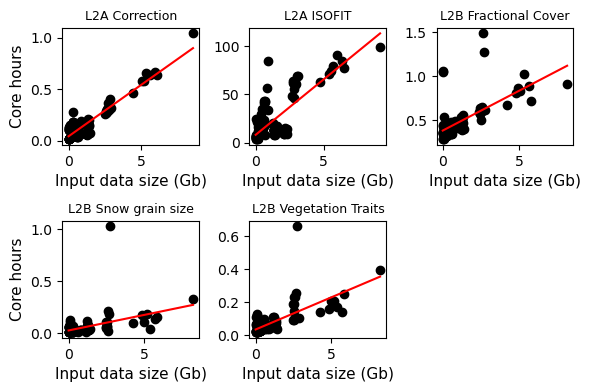

In [146]:
PGEs = {'L2A_RFL':'L2A ISOFIT',
         'L2A_CORFL':'L2A Correction',
         'L2B_FRCOVER':'L2B Fractional Cover',
         'L2B_GRAINSIZE':'L2B Snow grain size',
         'L2B_VEGBIOCHEM':'L2B Vegetation Traits',}


sensors = {'AVCL': 'AVIRIS-CL',
           'AVNG': 'AVIRIS-NG',
           'PRISMA':'PRISMA',
           'DESIS':'DESIS'}

fig = plt.figure(figsize = (6,4))
a = 1
for p,pge in prod_complete.groupby(by = 'PGE'):
    if p in PGEs.keys():

        x =pge['inputs_disk_usage'].values.astype(float)
        y =pge['core_hours'].values.astype(float)

        predict_x =np.linspace(0,x.max())

        b1,b0 = np.round(np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T,
                                y, rcond=None)[0],3)
        print(','.join([PGEs[p],str(b1),str(b0)]))
        
        predict_y = predict_x*b1 + b0

        equation = f'y = {b1}x + {b0}'

        ax = fig.add_subplot(2,3,a)
        ax.set_title(PGEs[p],fontsize = 9)

        ax.scatter(x,y,c = 'k')
        ax.plot(predict_x,predict_y,c = 'r')
        if a in [1,4]:
            ax.set_ylabel('Core hours',fontsize = 11)
        ax.set_xlabel('Input data size (Gb)',fontsize = 11)
        a+=1
        
fig.tight_layout(pad=1.0)    

plt.savefig(f'./input_v_core_hours.png',
            dpi = 300, bbox_inches= 'tight')


L2A Correction,0.957,-0.01
L2A ISOFIT,1.889,0.001
L2B Fractional Cover,0.011,0.002
L2B Snow grain size,0.0,0.0
L2B Vegetation Traits,0.012,-0.0


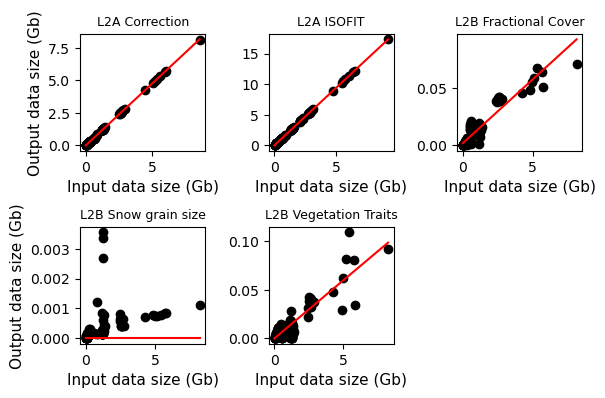

In [141]:
PGEs = {'L2A_RFL':'L2A ISOFIT',
         'L2A_CORFL':'L2A Correction',
         'L2B_FRCOVER':'L2B Fractional Cover',
         'L2B_GRAINSIZE':'L2B Snow grain size',
         'L2B_VEGBIOCHEM':'L2B Vegetation Traits',}


sensors = {'AVCL': 'AVIRIS-CL',
           'AVNG': 'AVIRIS-NG',
           'PRISMA':'PRISMA',
           'DESIS':'DESIS'}

fig = plt.figure(figsize = (6,4))
a = 1
    
for p,pge in prod_complete.groupby(by = 'PGE'):
    if p in PGEs.keys():

        x =pge['inputs_disk_usage'].values.astype(float)
        y =pge['staged_disk_usage'].values.astype(float)

        predict_x =np.linspace(0,x.max())

        b1,b0 = np.round(np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T,
                                y, rcond=None)[0],3)
        print(','.join([PGEs[p],str(b1),str(b0)]))
        
        predict_y = predict_x*b1 + b0

        equation = f'y = {b1}x + {b0}'

        ax = fig.add_subplot(2,3,a)
        ax.set_title(PGEs[p],fontsize = 9)

        ax.scatter(x,y,c = 'k')
        ax.plot(predict_x,predict_y,c = 'r')
        if a in [1,4]:
            ax.set_ylabel('Output data size (Gb)',fontsize = 11)
        ax.set_xlabel('Input data size (Gb)',fontsize = 11)
        a+=1
        
fig.tight_layout(pad=1.0)    

plt.savefig(f'./input_v_output_data.png',
            dpi = 300, bbox_inches= 'tight')
    
    